# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 1.10.2021

Мягкий дедлайн: 17.10.2021 23:59 МСК

Жесткий дедлайн: 24.10.2021 23:59 МСК (1 неделя -- минус балл)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Загрузите решение в свой репозиторий на github и поделитесь [ссылкой на решение в форме](https://forms.gle/ZzCaqRj6bmfpSpyL7). Не забудьте дать доступ к Вашему репозиторию, что у преподавателей была возмоожность проверить работу.

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [59]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from types import MethodType
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
        self.pca = PCA(self.new_dim) if self.use_PCA else None
        if self.classifier == "logreg":    
            self.model = LogisticRegression(solver="sag")
        elif self.classifier == "svm":
            self.model = SVC(kernel="linear")
        else:
            raise ValueError("Incorrect classifier name. Must be 'logreg' or 'svm'."
                             " Passed '%s'" % str(self.classifier))
        self.sigma = None
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:
            X = self.pca.fit_transform(X)
        
        else:
            self.new_dim = X.shape[1]
        
        self.sigma = self._fit_sigma(X)
        w, b = self._weights_sampler
        self.w = w
        self.b = b
        X = self._rff(X)
        
        self.model.fit(X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:
            X = self.pca.transform(X)
        X = self._rff(X)
        return self.model.predict_proba(X)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:
            X = self.pca.transform(X)
        X = self._rff(X)
        return self.model.predict(X)
        
    def _rff(self, X):
        return np.cos(X @ self.w + self.b)
    
    @property
    def _weights_sampler(self):
        w = np.random.normal(
            loc=0, scale=1 / self.sigma, 
            size=(self.new_dim, self.n_features)
        )
        b = np.random.uniform(
            low=-np.pi, high=np.pi, size=(self.n_features)
        )
        return w, b
    
    def _fit_sigma(self, X):
        pairs = self._random_pairs(X.shape[0], nsamp=1000000)
        sigma = np.median(
                    np.sum((X[pairs[0, :]] - X[pairs[1, :]])**2, axis=1)
                )
        # почему-то так оно работает, иначе - нет
        # думаю дело в предобработке, которую PCA из sklearn делает под капотом
        if self.use_PCA:
            return np.sqrt(sigma)
        else:
            return sigma
        
    def _random_pairs(self, dim, nsamp=1000000):
        x = np.random.choice(range(dim), size=nsamp)
        y = np.random.choice(range(dim), size=nsamp)
        pairs = np.concatenate((x[None, :], y[None, :]))
        pairs = pairs[:, pairs[0, :] != pairs[1, :]]
        return pairs

In [3]:
%%time
rff = RFFPipeline()
rff.fit(x_train, y_train)

y_pred = rff.predict(x_test)
print("Accuracy on test set = %.4f" % (y_test == y_pred).mean())

C:\Users\konqe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Accuracy on test set = 0.8780
Wall time: 6min 21s


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [4]:
x_train_subset, _, y_train_subset, _ = train_test_split(x_train, y_train, 
                                                  test_size=0.9, stratify=y_train, random_state=0)

x_train_subset.shape, y_train_subset.shape

((6000, 784), (6000,))

In [5]:
%%time
# тут тоже работало очень долго, если на всех объектах
svm_lin = SVC(kernel="linear")

svm_lin.fit(x_train_subset, y_train_subset)

y_pred = svm_lin.predict(x_test)
print("Accuracy on test set = %.4f" % (y_test == y_pred).mean())

Accuracy on test set = 0.7966
Wall time: 54.1 s


In [11]:
%%time
svm_rbf = SVC(kernel="rbf")

svm_rbf.fit(x_train_subset, y_train_subset)

y_pred = svm_rbf.predict(x_test)
print("Accuracy on test set = %.4f" % (y_test == y_pred).mean())

Accuracy on test set = 0.8416
Wall time: 1min 1s


In [16]:
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [19]:
%%time

lgbm = LGBMClassifier(n_estimators=1000,  learning_rate=1e-2)

lgbm.fit(x_train_pca, y_train)

y_pred = lgbm.predict(x_test_pca)
print("Accuracy on test set = %.4f" % (y_test == y_pred).mean())

Accuracy on test set = 0.8707
Wall time: 1min 13s


__Выводы__:
Линейный и ядровой SVM на всех объектах обучались очень долго (оставлял примерно на час каждый - без результатов). Получилось обучить только на одной десятой выборки - в принципе можно сказать, что для RBF ядра результаты сравнимы (учитывая, что объем выборки намного меньше), но и время обучения больше. Хотя в лоб сравнивать тоже не совсем правильно - все таки в RFF мы использовали PCA.

Что качается бустинга + PCA - хочется сказать, что такой вариант выглядит получше - кач-во плюс минус такое же + работает быстрее.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [60]:
%%time
rff_no_pca = RFFPipeline(use_PCA=False)
rff_no_pca.fit(x_train, y_train)

print("Accuracy on test set = %.4f" % (y_test == rff_no_pca.predict(x_test)).mean())
print("Accuracy on train set = %.4f" % (y_train == rff_no_pca.predict(x_train)).mean())

C:\Users\konqe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Accuracy on test set = 0.8350
Accuracy on train set = 0.8515
Wall time: 3min 23s


In [35]:
%%time

metrics = []

for n_features in tqdm([100, 200, 300, 500, 800]):
    rff_temp = RFFPipeline(n_features=n_features)
    rff_temp.fit(x_train, y_train)
    train_acc = (y_train == rff_temp.predict(x_train)).mean()
    test_acc = (y_test == rff_temp.predict(x_test)).mean()
    metrics.append((train_acc, test_acc))

C:\Users\konqe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\konqe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\konqe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\konqe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\konqe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which mean


Wall time: 6min 42s


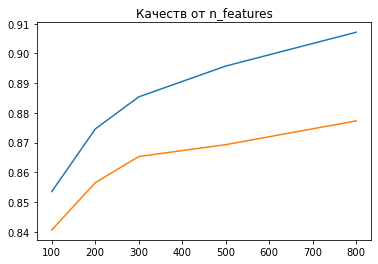

In [53]:
plt.title("Качеств от n_features")
plt.plot([100, 200, 300, 500, 800], [metric[0] for metric in metrics], label="train")
plt.plot([100, 200, 300, 500, 800], [metric[1] for metric in metrics], label="val")
plt.show()

In [54]:
%%time
rff = RFFPipeline(classifier="svm")
rff.fit(x_train, y_train)

y_pred = rff.predict(x_test)
print("Accuracy on test set = %.4f" % (y_test == y_pred).mean())

Accuracy on test set = 0.8808
Wall time: 13min 18s


__Выводы__:
1. В целом качество немного хуже (без PCA), так что считаем что PCA, по крайней мере в этой задаче, помогает
1. В целом качество повышается и начинает выходить на плато - сходится к истинной оценке
1. В этом примере особой разницы в метриках не наблюдается, только SVM обучается дольше. В принципе, ожидаемо по крайней мере для линейного ядра SVM.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [8]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
pass

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [76]:
def _rff_sign(self, X):
    return np.sign(X @ self.w + self.b)
    

def _rff_sigmoid(self, X):
    return 1 / (1 + np.exp(-(X @ self.w + self.b)))
    

def _rff(self, X):
    return 1 / (1 + np.exp(-(X @ self.w + self.b)))    

In [74]:
rff_sign = RFFPipeline()
rff_sign._rff = MethodType(_rff_sign, rff_sign)

rff_sign.fit(x_train, y_train)

print("Accuracy on test set = %.4f" % (y_test == rff_sign.predict(x_test)).mean())
print("Accuracy on train set = %.4f" % (y_train == rff_sign.predict(x_train)).mean())

C:\Users\konqe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Accuracy on test set = 0.8327
Accuracy on train set = 0.8610


In [75]:
rff_sigmoid = RFFPipeline()
rff_sigmoid._rff = MethodType(_rff_sigmoid, rff_sigmoid)

rff_sigmoid.fit(x_train, y_train)

print("Accuracy on test set = %.4f" % (y_test == rff_sigmoid.predict(x_test)).mean())
print("Accuracy on train set = %.4f" % (y_train == rff_sigmoid.predict(x_train)).mean())

C:\Users\konqe\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Accuracy on test set = 0.8572
Accuracy on train set = 0.8725


In [80]:
rff_rfc = RFFPipeline()
rff_rfc.model = RandomForestClassifier(random_state=42)

rff_rfc.fit(x_train, y_train)

print("Accuracy on test set = %.4f" % (y_test == rff_rfc.predict(x_test)).mean())
print("Accuracy on train set = %.4f" % (y_train == rff_rfc.predict(x_train)).mean())

Accuracy on test set = 0.8609
Accuracy on train set = 0.9993


__Вывод__:
1. Попробовали - sign и sigmoid. В обоих случаях качество немного меньше, но сигмоида вроде получше
1. Попробовали случайный лес - модель переобучилась. Но это дает надежду, что при определенных гиперпараметрах может получится что-то дельное.